In [1]:
# data stuff:
import pandas as pd
import numpy as np
import random

# modeling stuff:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import plot_importance

# optimization stuff:
import optuna

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


# plotting stuff:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

# silence!
import warnings
warnings.filterwarnings("ignore")

---
## Gradient Boosting with XGBoost and LightGBM:
Below we apply the two most popular gradient boosting algorithms to the forecasting of traffic volume using the Metro Interstate dataset found in the UCI repository.

See paper below for in-depth study of the use-case:

https://www.researchgate.net/publication/356836799_XGBoost_a_tree-based_approach_for_traffic_volume_prediction

---

### Import data:

In [2]:
data = pd.read_csv('data/Metro_Interstate_Traffic_Volume.csv')
data

holiday    temp  rain_1h  snow_1h  clouds_all  weather_main  \
0        None  288.28      0.0      0.0          40        Clouds   
1        None  289.36      0.0      0.0          75        Clouds   
2        None  289.58      0.0      0.0          90        Clouds   
3        None  290.13      0.0      0.0          90        Clouds   
4        None  291.14      0.0      0.0          75        Clouds   
...       ...     ...      ...      ...         ...           ...   
48199    None  283.45      0.0      0.0          75        Clouds   
48200    None  282.76      0.0      0.0          90        Clouds   
48201    None  282.73      0.0      0.0          90  Thunderstorm   
48202    None  282.09      0.0      0.0          90        Clouds   
48203    None  282.12      0.0      0.0          90        Clouds   

          weather_description            date_time  traffic_volume  
0            scattered clouds  2012-10-02 09:00:00            5545  
1               broken clouds  2012-10-02 10:00:00            4516  
2             overcast clouds  2012-10-02 11:00:00            4767  
3             overcast clouds  2012-10-02 12:00:00            5026  
4               broken clouds  2012-10-02 13:00:00            4918  
...                       ...                  ...             ...  
48199           broken clouds  2018-09-30 19:00:00            3543  
48200         overcast clouds  2018-09-30 20:00:00            2781  
48201  proximity thunderstorm  2018-09-30 21:00:00            2159  
48202         overcast clouds  2018-09-30 22:00:00            1450  
48203         overcast clouds  2018-09-30 23:00:00             954  

[48204 rows x 9 columns]

### Apply feature engineering:
We create datetime features to aid in the search for a best fit.

In [3]:
# increase granularity of the datetime feature, and create a holiday indicator:
data['date_time'] = pd.to_datetime(data['date_time'])
data['date'] = data['date_time'].dt.date
data['year'] = data['date_time'].dt.year
data['month'] = data['date_time'].dt.month
data['week'] = data['date_time'].dt.week
data['weekday'] = data['date_time'].dt.dayofweek
data['hour'] = data['date_time'].dt.hour
data['is_holiday'] = data['holiday'].apply(lambda x: 1.0 if x != 'None' else 0.0)

# weekends and bad weather:
data['is_weekend'] = data['weekday'].apply(lambda x: 1.0 if x in [5,6] else 0.0)
data['is_bad_weather'] = (data['snow_1h'] +  data['rain_1h']).apply(lambda x: 1.0 if x > 0 else 0.0)

# rush hour:
morning_rush = data['hour'].between(5,10)
evening_rush = data['hour'].between(15,20)
data['is_peak_hour'] = np.where(morning_rush | evening_rush, 1.0, 0.0)

# set datetime as index for better visualization:
data.set_index('date_time', inplace=True)
data

holiday    temp  rain_1h  snow_1h  clouds_all  \
date_time                                                           
2012-10-02 09:00:00    None  288.28      0.0      0.0          40   
2012-10-02 10:00:00    None  289.36      0.0      0.0          75   
2012-10-02 11:00:00    None  289.58      0.0      0.0          90   
2012-10-02 12:00:00    None  290.13      0.0      0.0          90   
2012-10-02 13:00:00    None  291.14      0.0      0.0          75   
...                     ...     ...      ...      ...         ...   
2018-09-30 19:00:00    None  283.45      0.0      0.0          75   
2018-09-30 20:00:00    None  282.76      0.0      0.0          90   
2018-09-30 21:00:00    None  282.73      0.0      0.0          90   
2018-09-30 22:00:00    None  282.09      0.0      0.0          90   
2018-09-30 23:00:00    None  282.12      0.0      0.0          90   

                     weather_main     weather_description  traffic_volume  \
date_time                                                                   
2012-10-02 09:00:00        Clouds        scattered clouds            5545   
2012-10-02 10:00:00        Clouds           broken clouds            4516   
2012-10-02 11:00:00        Clouds         overcast clouds            4767   
2012-10-02 12:00:00        Clouds         overcast clouds            5026   
2012-10-02 13:00:00        Clouds           broken clouds            4918   
...                           ...                     ...             ...   
2018-09-30 19:00:00        Clouds           broken clouds            3543   
2018-09-30 20:00:00        Clouds         overcast clouds            2781   
2018-09-30 21:00:00  Thunderstorm  proximity thunderstorm            2159   
2018-09-30 22:00:00        Clouds         overcast clouds            1450   
2018-09-30 23:00:00        Clouds         overcast clouds             954   

                           date  year  month  week  weekday  hour  is_holiday  \
date_time                                                                       
2012-10-02 09:00:00  2012-10-02  2012     10    40        1     9         0.0   
2012-10-02 10:00:00  2012-10-02  2012     10    40        1    10         0.0   
2012-10-02 11:00:00  2012-10-02  2012     10    40        1    11         0.0   
2012-10-02 12:00:00  2012-10-02  2012     10    40        1    12         0.0   
2012-10-02 13:00:00  2012-10-02  2012     10    40        1    13         0.0   
...                         ...   ...    ...   ...      ...   ...         ...   
2018-09-30 19:00:00  2018-09-30  2018      9    39        6    19         0.0   
2018-09-30 20:00:00  2018-09-30  2018      9    39        6    20         0.0   
2018-09-30 21:00:00  2018-09-30  2018      9    39        6    21         0.0   
2018-09-30 22:00:00  2018-09-30  2018      9    39        6    22         0.0   
2018-09-30 23:00:00  2018-09-30  2018      9    39        6    23         0.0   

                     is_weekend  is_bad_weather  is_peak_hour  
date_time                                                      
2012-10-02 09:00:00         0.0             0.0           1.0  
2012-10-02 10:00:00         0.0             0.0           1.0  
2012-10-02 11:00:00         0.0             0.0           0.0  
2012-10-02 12:00:00         0.0             0.0           0.0  
2012-10-02 13:00:00         0.0             0.0           0.0  
...                         ...             ...           ...  
2018-09-30 19:00:00         1.0             0.0           1.0  
2018-09-30 20:00:00         1.0             0.0           1.0  
2018-09-30 21:00:00         1.0             0.0           0.0  
2018-09-30 22:00:00         1.0             0.0           0.0  
2018-09-30 23:00:00         1.0             0.0           0.0  

[48204 rows x 18 columns]

### Plot:

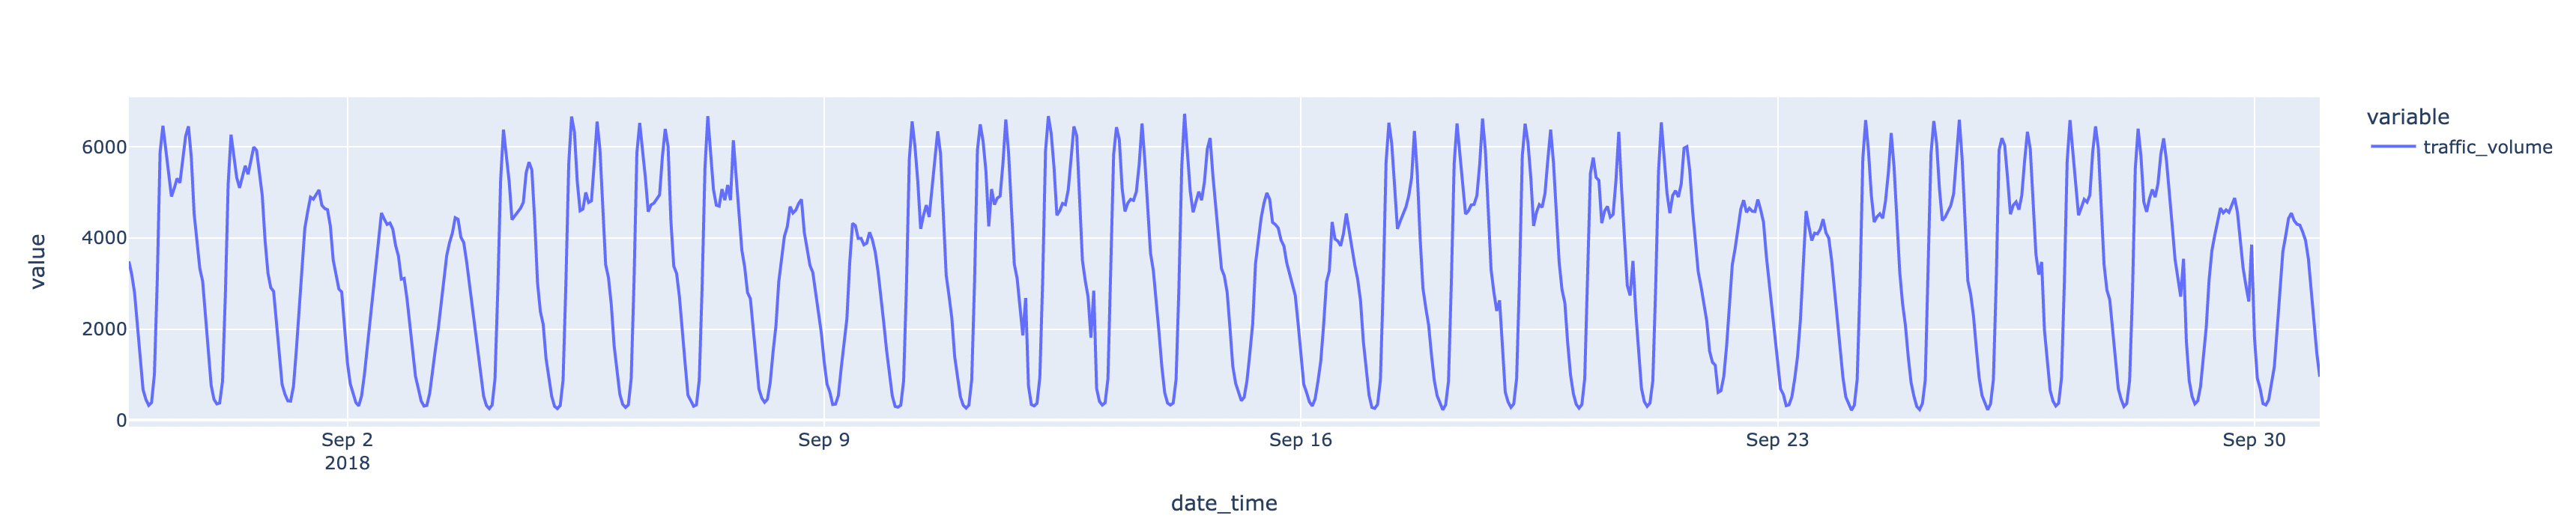

In [4]:
# plot traffic volume:
px.line(data['traffic_volume'][-1000:])
Image(filename='./images/ch15_rawseries.png', width=1800)

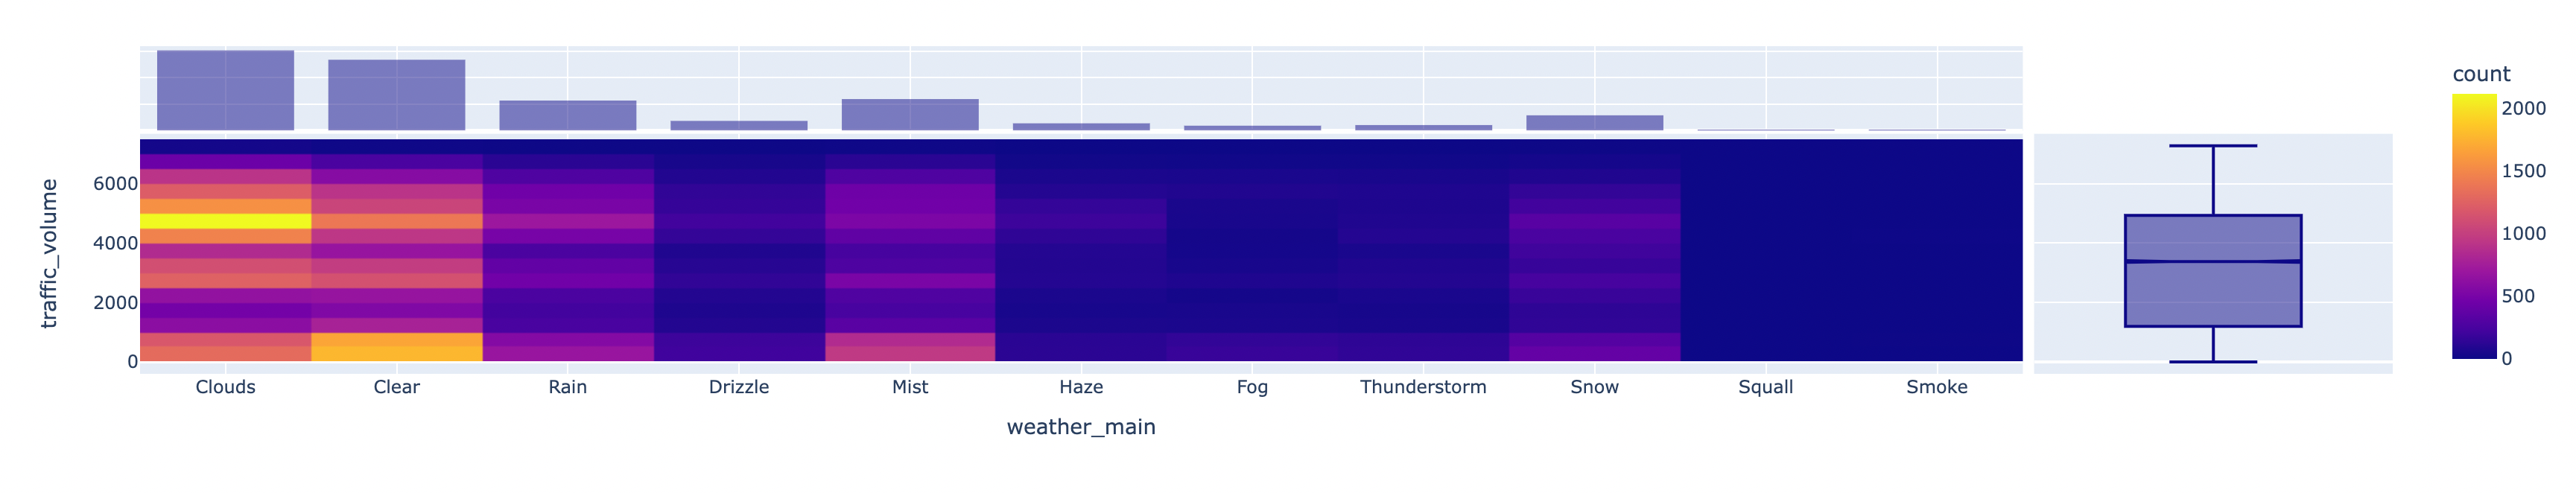

In [5]:
# plot relationship between traffic volume and weather events:
px.density_heatmap(data, x="weather_main", y="traffic_volume", marginal_x="histogram", marginal_y="box")
Image(filename='./images/ch15_heatmap.png', width=1800)

&nbsp;

### Prepare data for modeling:

In [29]:
# Create objects predictor and target variables:
X = data[['year', 'month', 'week', 'weekday', 'is_holiday', 'hour', 'is_weekend', 'is_bad_weather', 'is_peak_hour']]
y = data['traffic_volume']

# split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

&nbsp;

### Fit (initial) XGB regressor:

In [30]:
# initialize and fit:
my_xgb = XGBRegressor()
my_xgb.fit(X_train, y_train)

# predict:
xgb_fcst = my_xgb.predict(X_test)
xgb_score = r2_score(list(y_test), list(xgb_fcst))
print(xgb_score)

0.9332580309138282


&nbsp;

### Fit (initial) LightGBM Regressor:

In [8]:
# initialize and fit:
my_lgbm = LGBMRegressor()
my_lgbm.fit(X_train, y_train)

# predict:
lgbm_fcst = my_lgbm.predict(X_test)
lgbm_score = r2_score(list(y_test), list(lgbm_fcst))
print(lgbm_score)

0.9366445775690148


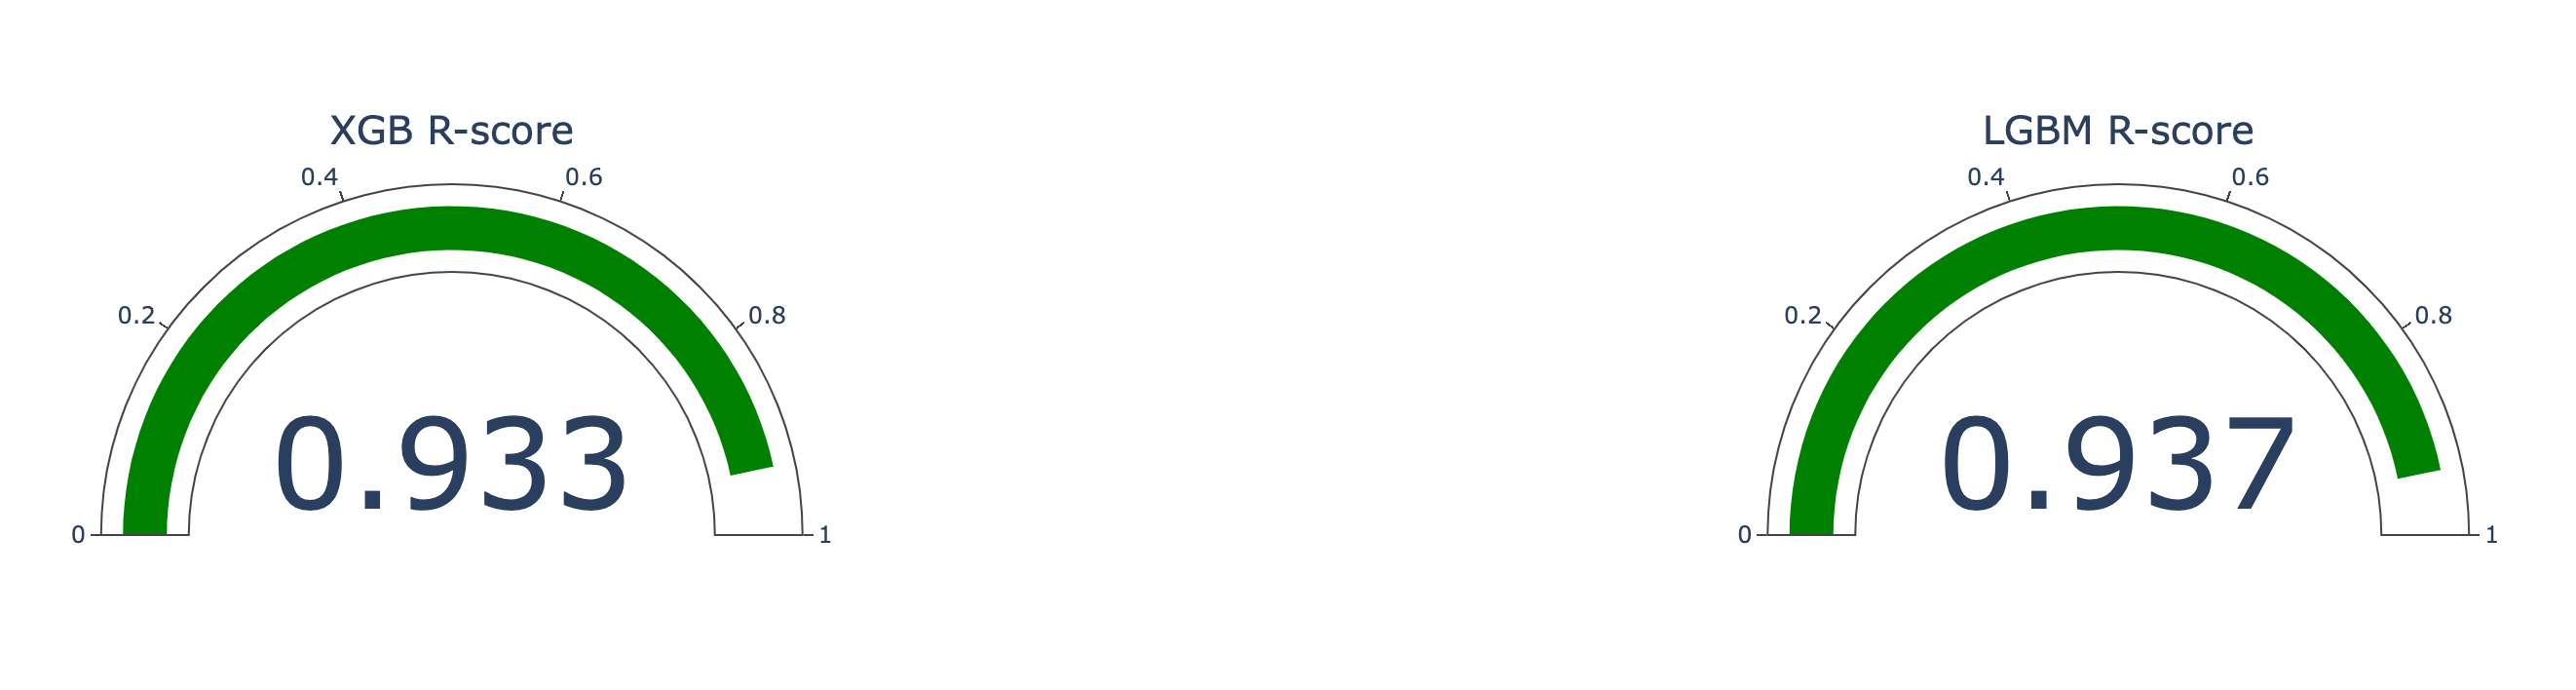

In [9]:
# R-squared values:
r_fig = make_subplots(
    rows=1,
    cols=2,
    column_widths=[0.1, 0.1],
    specs=[[{'type' : 'indicator'}, {'type' : 'indicator'}]])

r_fig.append_trace(go.Indicator(
    mode = "gauge+number",
    value = xgb_score,
    title = {'text': "XGB R-score"},
    gauge = {'axis': {'range': [0, 1]}},),
               row=1, col=1)

r_fig.append_trace(go.Indicator(
    mode = "gauge+number",
    value = lgbm_score,
    title = {'text': "LGBM R-score"},
    gauge = {'axis': {'range': [0, 1]}},),
               row=1, col=2)
r_fig
Image(filename='./images/ch15_fitscores.png', width=1200)

### Plot initial Results:

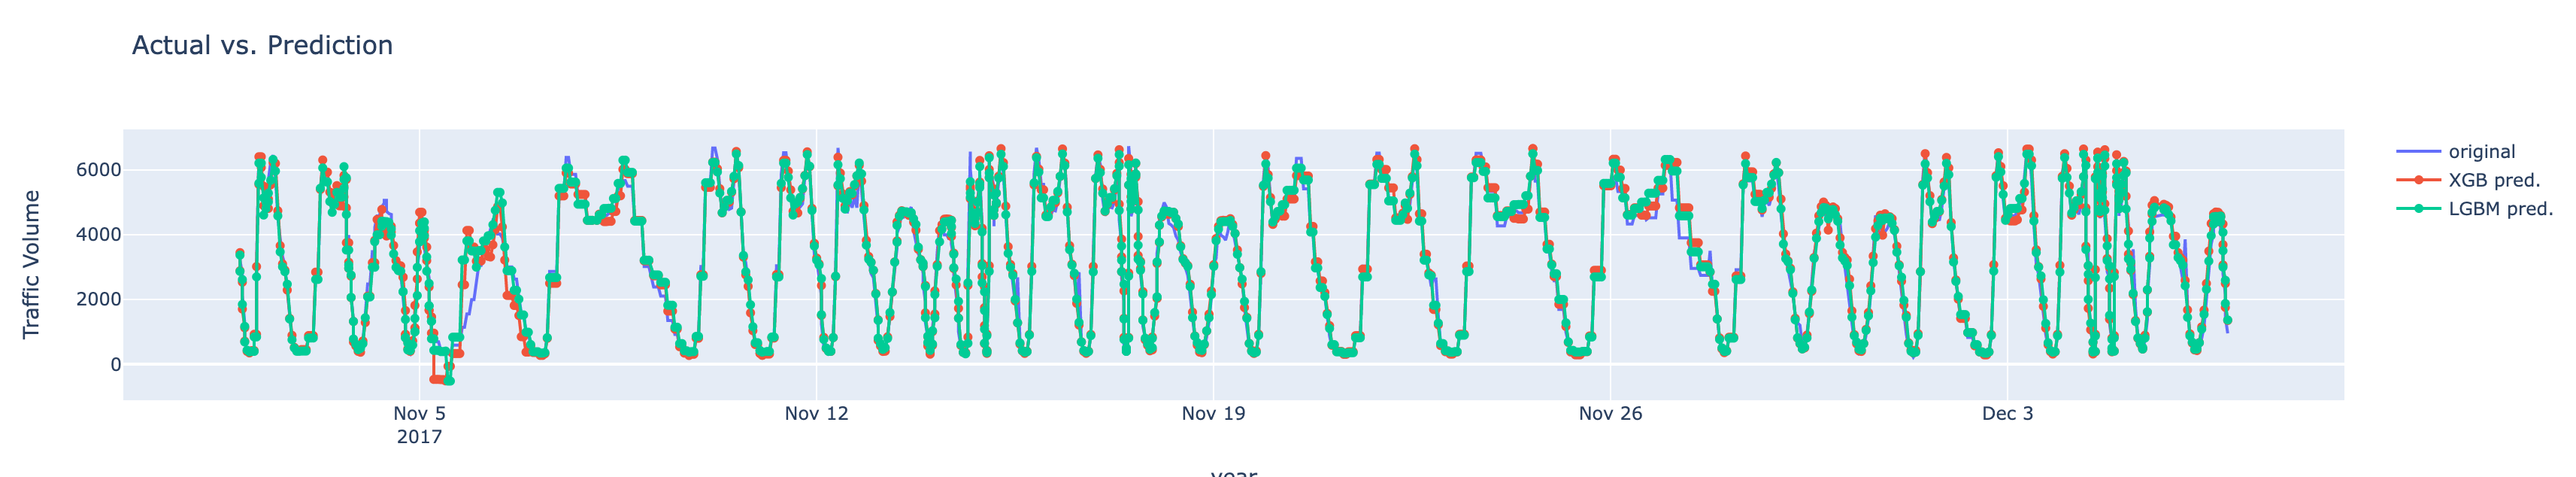

In [10]:
fig = go.Figure()

# actual:
fig.add_trace(go.Scatter(x=list(y_test.index), y=y_test[-1000:], mode='lines', name='original'))
# predicted XGB:
fig.add_trace(go.Scatter(x=list(y_test.index), y=xgb_fcst[-1000:], mode='lines+markers', name='XGB pred.'))
# predicted LightGBM:
fig.add_trace(go.Scatter(x=list(y_test.index), y=lgbm_fcst[-1000:], mode='lines+markers', name='LGBM pred.'))

fig.update_layout(
    title="Actual vs. Prediction",
    xaxis_title="year",
    yaxis_title="Traffic Volume")
Image(filename='./images/ch15_preds.png', width=1800)

&nbsp;

### Bayesian Hyperparameter tuning with Scikit Optimize and Optuna:
"In Bayesian optimization, rather than trying out every combination of hyperparameters
or just trying out random guesses, we can make intelligent guesses by modeling
the likelihood of a certain value for the hyperparameters to be the optimum. This is done
by modeling a probability distribution around the hyperparameters. 

Bayesian optimization will start sampling a number of values of the hyperparameter and observe
the model performance at those points.

The goal is not to randomly fall on one value that performs well, but rather to
estimate the gray zone around the curve. Some values of the hyperparameter will give
better performance than others. While testing values, Bayesian optimization makes a
model of the probability distribution of the optimum being at this location.
In this way, Bayesian optimization is much more intelligent than standard grid search techniques. It can make intelligent, probability-based guesses
about the points that should be tested next. This makes it much more powerful for
optimizing hyperparameters."

See "Advanced Forecasting with Python" page 201.

#### ScikitOP:

In [11]:
xgb_opt = BayesSearchCV(
    XGBRegressor(),
    {
        'learning_rate': (10e-6, 1.0, 'log-uniform'),
        'max_depth': Integer(0, 50, 'uniform'),
        'n_estimators' : (10, 1000, 'log-uniform'),
        'subsample' : (10e-6, 1.0, 'log-uniform'), 
        'colsample_bytree' : (10e-6, 1.0, 'log-uniform'),
        'reg_alpha': (10e-6, 1.0, 'log-uniform'),
        'reg_lambda': (10e-6, 1.0, 'log-uniform'),
        'gamma': (10e-6, 1.0, 'log-uniform')
    },
    n_iter=10,
    cv=10
)

xgb_opt.fit(X_train, y_train)
xgb_tuned_fcst = xgb_opt.best_estimator_.predict(X_test)
r2_score(list(y_test), list(xgb_tuned_fcst))

-2.4671221946119313

In [12]:
xgb_opt.best_params_

OrderedDict([('colsample_bytree', 0.18596859805365584),
             ('gamma', 0.7812665492595575),
             ('learning_rate', 0.0020486916345125446),
             ('max_depth', 7),
             ('n_estimators', 79),
             ('reg_alpha', 0.0008766980086227052),
             ('reg_lambda', 0.21616294294538446),
             ('subsample', 1.5579666708430174e-05)])

#### Optuna (XGB):

In [13]:
def objective_xgb_cv(trial):
    # xgb params:
    learning_rate=trial.suggest_float("learning_rate", 0.01, 1, step=0.01)
    max_depth=trial.suggest_int('max_depth', 1, 50, step=1)
    n_estimators=trial.suggest_int('n_estimators', 1, 1000, step=10)
    subsample=trial.suggest_float("subsample", 0.01, 1, step=0.01)
    colsample_bytree=trial.suggest_float("colsample_bytree", 0.01, 1, step=0.01)
    reg_alpha=trial.suggest_float("reg_alpha", 0.0, 1, step=0.01)
    reg_lambda=trial.suggest_float("reg_lambda", 0.0, 1, step=0.01)
    gamma=trial.suggest_float("gamma", 0.0, 1, step=0.01)
    
    # initialize model with trial vals:
    params = {'learning_rate': learning_rate,
              'max_depth': max_depth,
              'n_estimators': n_estimators,
              'subsample': subsample, 
              'colsample_bytree': colsample_bytree,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'gamma': gamma
             }
    
    # initialize:
    xgb_r=XGBRegressor().set_params(**params)
    
    # obtain mean score for the folds:
    val_score = np.mean(cross_val_score(xgb_r, X, y, cv=10))

    return val_score

In [14]:
# find optimal params (orders) that will maximize R-squared value:
study_cv=optuna.create_study(direction="maximize")
study_cv.optimize(objective_xgb_cv, n_trials=15)

[I 2022-06-11 07:15:51,193] A new study created in memory with name: no-name-1398830c-c139-47b6-9ba1-e449fba643c3
[I 2022-06-11 07:16:36,614] Trial 0 finished with value: 0.8258062810409676 and parameters: {'learning_rate': 0.18000000000000002, 'max_depth': 25, 'n_estimators': 461, 'subsample': 0.76, 'colsample_bytree': 0.2, 'reg_alpha': 0.9500000000000001, 'reg_lambda': 0.71, 'gamma': 0.75}. Best is trial 0 with value: 0.8258062810409676.
[I 2022-06-11 07:20:12,090] Trial 1 finished with value: 0.9097685736796798 and parameters: {'learning_rate': 0.33, 'max_depth': 14, 'n_estimators': 421, 'subsample': 0.43, 'colsample_bytree': 0.8200000000000001, 'reg_alpha': 0.6900000000000001, 'reg_lambda': 0.71, 'gamma': 0.49}. Best is trial 1 with value: 0.9097685736796798.
[I 2022-06-11 07:21:35,638] Trial 2 finished with value: 0.8258877154744043 and parameters: {'learning_rate': 0.09999999999999999, 'max_depth': 10, 'n_estimators': 791, 'subsample': 0.43, 'colsample_bytree': 0.19, 'reg_alpha':

In [15]:
# optimal result and corresponding params:
trial_cv=study_cv.best_trial

# top r-squared value:
trial_value_cv = np.round(trial_cv.value, 3)

print(f"R-squared: {trial_value_cv}")
print("best params for XGB: {}".format(trial_cv.params))

R-squared: 0.932
best params for XGB: {'learning_rate': 0.09999999999999999, 'max_depth': 9, 'n_estimators': 341, 'subsample': 0.51, 'colsample_bytree': 0.26, 'reg_alpha': 0.03, 'reg_lambda': 0.92, 'gamma': 0.21}


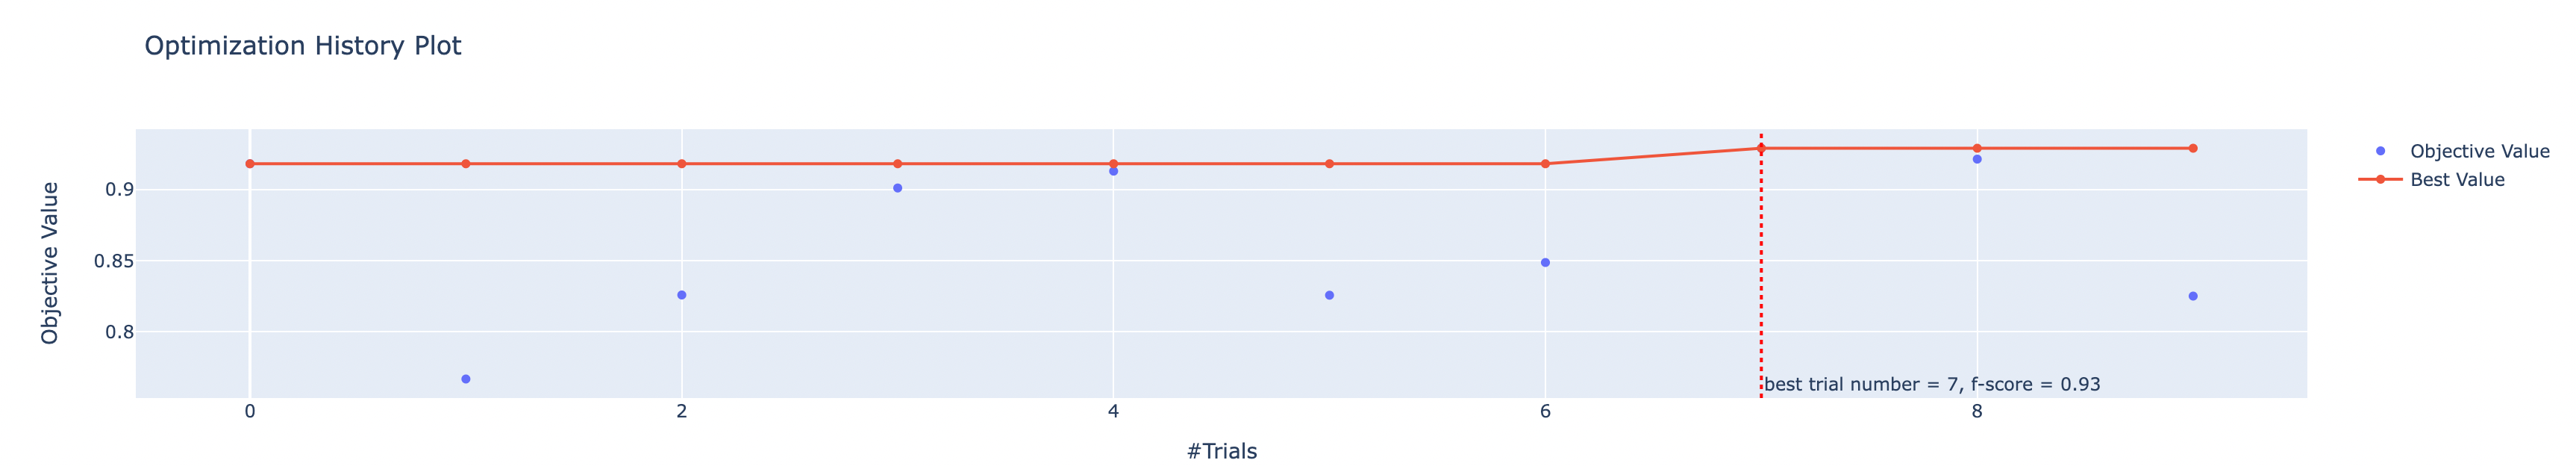

In [16]:
best_trial = study_cv.best_trial.number
best_trial_val = np.round(study_cv.best_trial.values[0], 2)
study_fig = optuna.visualization.plot_optimization_history(study_cv)
study_fig.add_vline(x=best_trial, line_dash="dot", line_color='red', annotation_text=f"best trial number = {best_trial}, f-score = {best_trial_val}", annotation_position="bottom right")
study_fig
Image(filename='./images/ch15_optunafit1.png', width=1800)

### Fit best XGB model:

In [17]:
# initialize random forest model:
final_xgb_cv = XGBRegressor().set_params(**study_cv.best_params)
final_xgb_cv.fit(X_train, y_train)

# predict:
final_fcst_cv = final_xgb_cv.predict(X_test)

# evaluate:
final_cv_score = np.round(r2_score(list(y_test), list(final_fcst_cv)), 3)

In [18]:
final_cv_score

0.933

#### Feature Importance:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

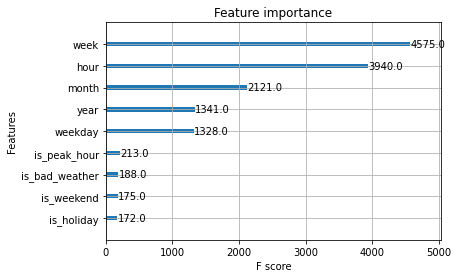

In [19]:
plot_importance(final_xgb_cv)

&nbsp;

### Optuna (LGBM):

In [20]:
def objective_lgbm_cv(trial):
    # xgb params:
    learning_rate=trial.suggest_float("learning_rate", 0.01, 1, step=0.01)
    max_depth=trial.suggest_int('max_depth', 1, 50, step=1)
    n_estimators=trial.suggest_int('n_estimators', 1, 1000, step=10)
    subsample=trial.suggest_float("subsample", 0.01, 1, step=0.01)
    colsample_bytree=trial.suggest_float("colsample_bytree", 0.01, 1, step=0.01)
    reg_alpha=trial.suggest_float("reg_alpha", 0.0, 1, step=0.01)
    reg_lambda=trial.suggest_float("reg_lambda", 0.0, 1, step=0.01)
    
    # initialize model with trial vals:
    params = {'learning_rate': learning_rate,
              'max_depth': max_depth,
              'n_estimators': n_estimators,
              'subsample': subsample, 
              'colsample_bytree': colsample_bytree,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda
             }
    
    # initialize:
    lgbm_r=LGBMRegressor().set_params(**params)
    
    # obtain mean score for the folds:
    val_score = np.mean(cross_val_score(lgbm_r, X, y, cv=10))

    return val_score

In [21]:
# find optimal params (orders) that will maximize R-squared value:
study_lgbm=optuna.create_study(direction="maximize")
study_lgbm.optimize(objective_lgbm_cv, n_trials=10)

[I 2022-06-11 07:43:16,166] A new study created in memory with name: no-name-3751f6f2-417b-4e03-8f8f-ca4715b928ec
[I 2022-06-11 07:43:40,476] Trial 0 finished with value: 0.9130984254814317 and parameters: {'learning_rate': 0.72, 'max_depth': 44, 'n_estimators': 111, 'subsample': 0.19, 'colsample_bytree': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 0.5700000000000001}. Best is trial 0 with value: 0.9130984254814317.
[I 2022-06-11 07:44:40,080] Trial 1 finished with value: 0.8979183813988971 and parameters: {'learning_rate': 0.89, 'max_depth': 30, 'n_estimators': 381, 'subsample': 0.48000000000000004, 'colsample_bytree': 0.9600000000000001, 'reg_alpha': 0.25, 'reg_lambda': 0.11}. Best is trial 0 with value: 0.9130984254814317.
[I 2022-06-11 07:45:19,205] Trial 2 finished with value: 0.8979118229582166 and parameters: {'learning_rate': 0.98, 'max_depth': 12, 'n_estimators': 351, 'subsample': 0.5800000000000001, 'colsample_bytree': 0.56, 'reg_alpha': 0.16, 'reg_lambda': 0.72}. Best is trial 0 wi

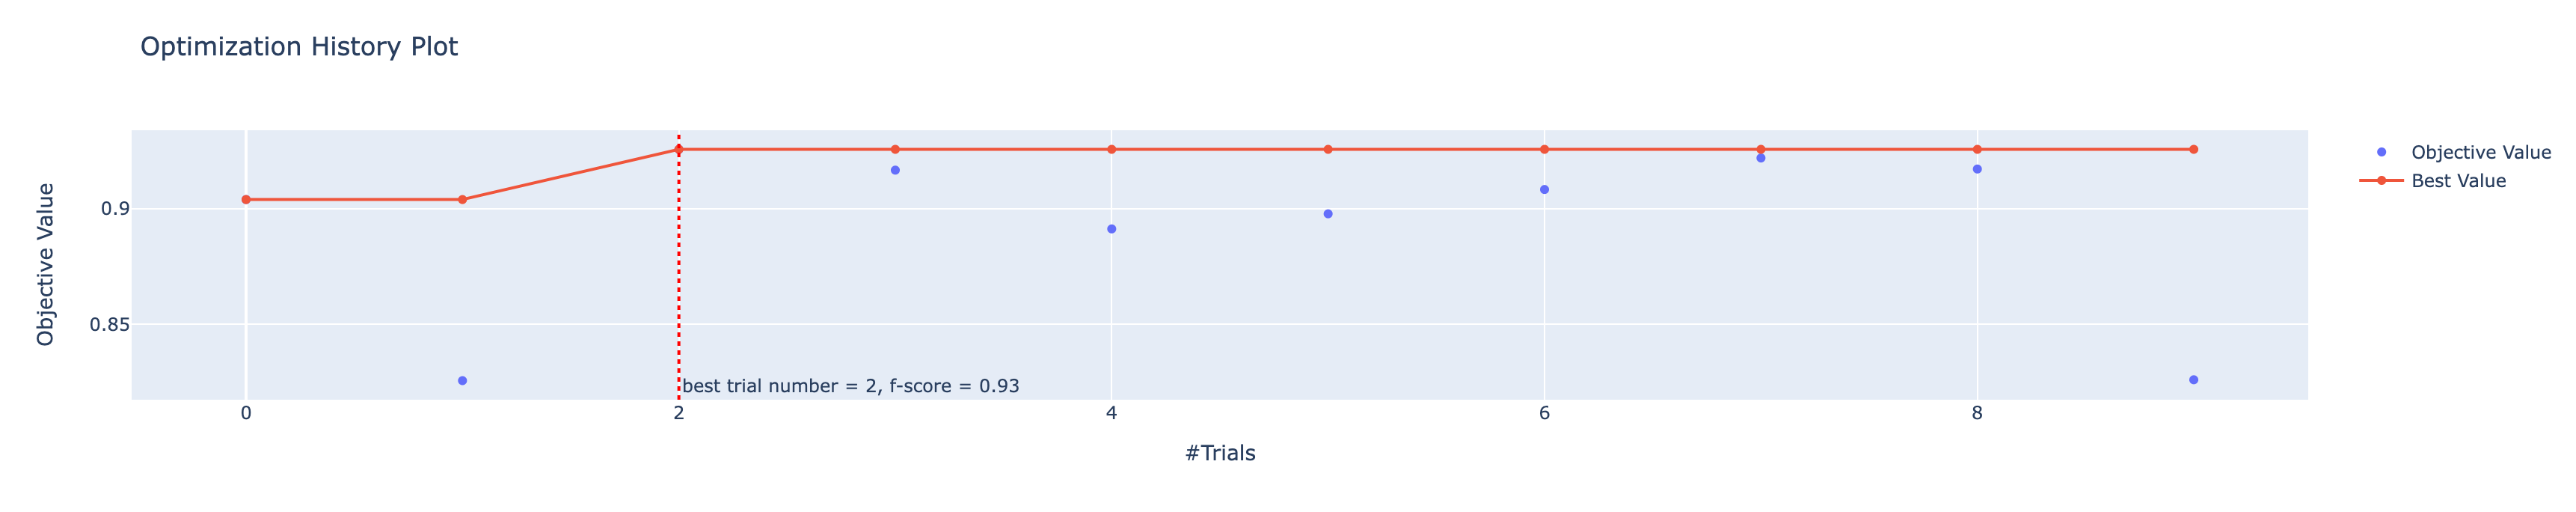

In [22]:
best_trial_lgbm = study_lgbm.best_trial.number
best_trial_val_lgbm = np.round(study_lgbm.best_trial.values[0], 2)
study_fig_lgbm = optuna.visualization.plot_optimization_history(study_lgbm)
study_fig_lgbm.add_vline(x=best_trial_lgbm, line_dash="dot", line_color='red', annotation_text=f"best trial number = {best_trial_lgbm}, f-score = {best_trial_val_lgbm}", annotation_position="bottom right")
study_fig_lgbm
Image(filename='./images/ch15_optunafitfinal.png', width=1800)

### Best fit (LGBM):

In [23]:
# initialize random forest model:
final_lgbm_cv = LGBMRegressor().set_params(**study_lgbm.best_params)
final_lgbm_cv.fit(X_train, y_train)

# predict:
final_fcst_lgbm = final_lgbm_cv.predict(X_test)

# evaluate:
final_lgbm_score = np.round(r2_score(list(y_test), list(final_fcst_lgbm)), 3)

In [24]:
final_lgbm_score

0.932

#### Feature Importance:

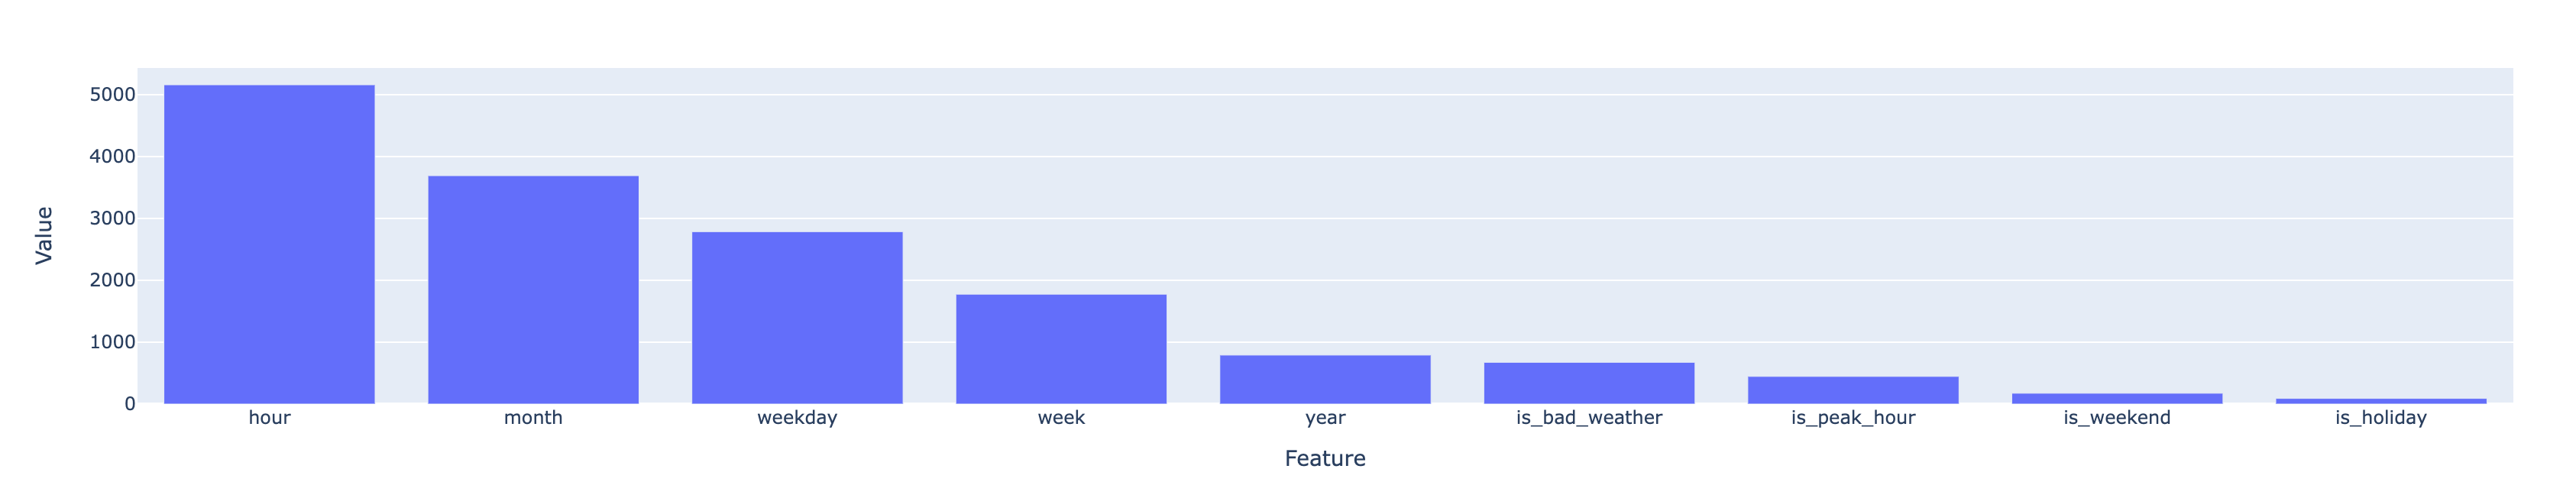

In [25]:
feature_imp = pd.DataFrame(sorted(zip(final_lgbm_cv.feature_importances_,X.columns)), columns=['Value','Feature']).sort_values(by="Value", ascending=False)
px.bar(feature_imp, y='Value', x='Feature')
Image(filename='./images/ch15_lgbmfi.png', width=1800)

---
### Final Model comparison and conclusions:


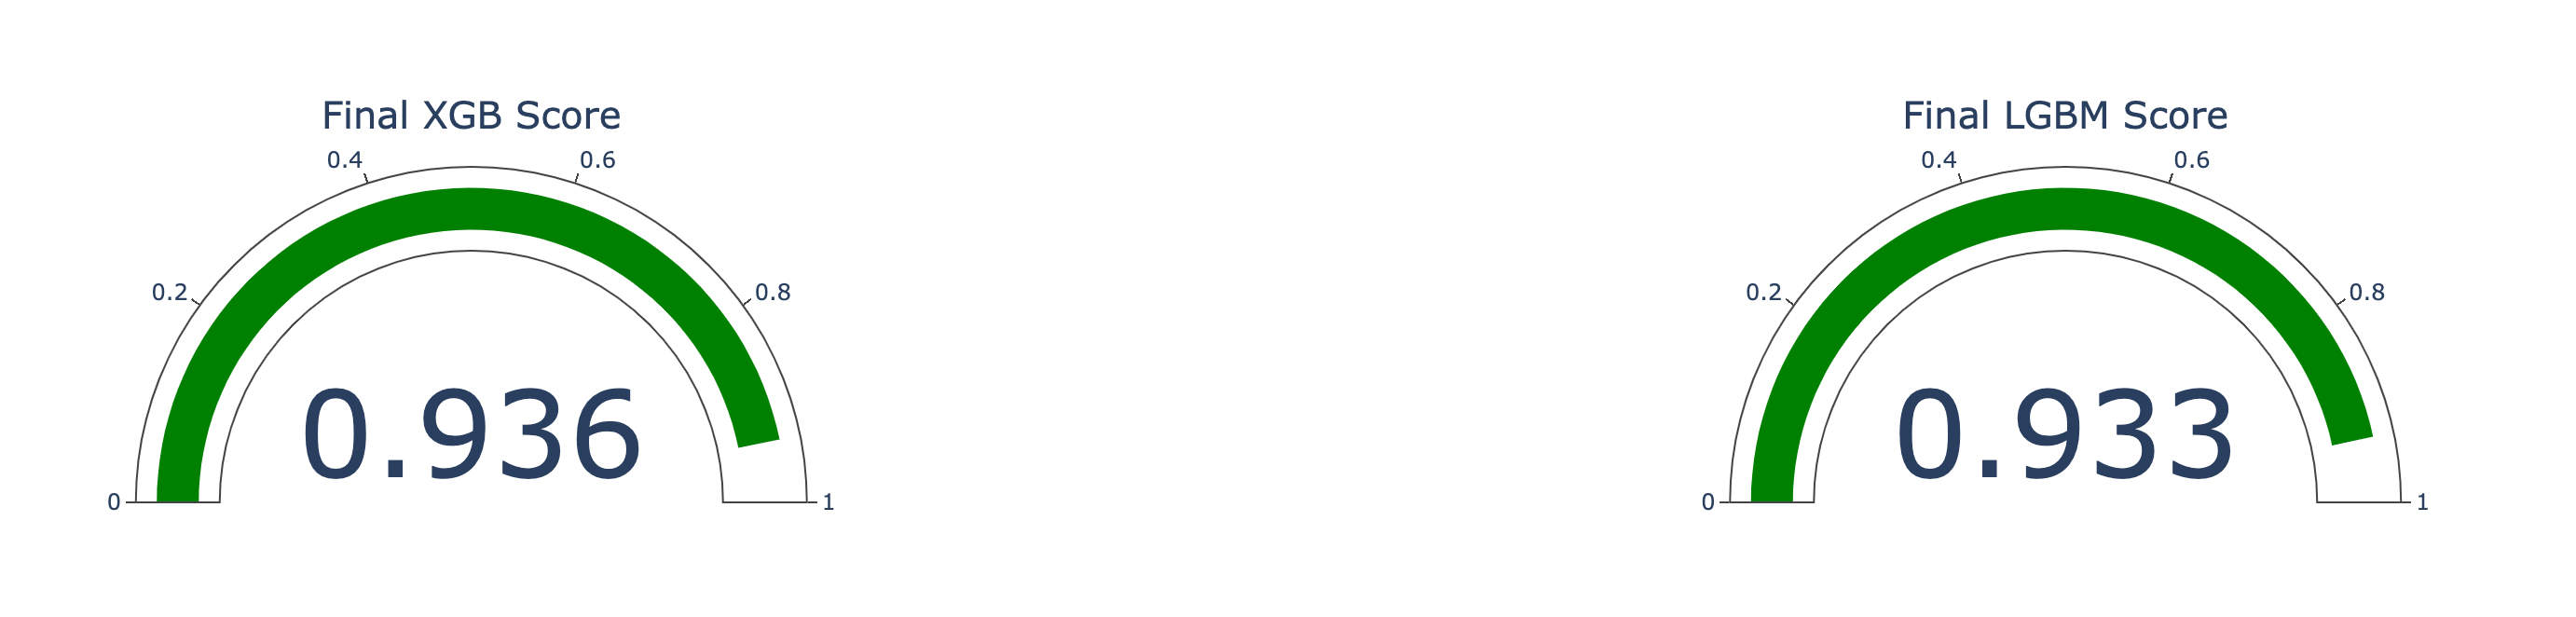

In [26]:
# R-squared values:
r_final = make_subplots(
    rows=1,
    cols=2,
    column_widths=[0.1, 0.1],
    specs=[[{'type' : 'indicator'}, {'type' : 'indicator'}]])

r_final.append_trace(go.Indicator(
    mode = "gauge+number",
    value = final_cv_score,
    title = {'text': "Final XGB Score"},
    gauge = {'axis': {'range': [0, 1]}},),
               row=1, col=1)

r_final.append_trace(go.Indicator(
    mode = "gauge+number",
    value = final_lgbm_score,
    title = {'text': "Final LGBM Score"},
    gauge = {'axis': {'range': [0, 1]}},),
               row=1, col=2)
r_final
Image(filename='./images/ch15_finalrs.png', width=1000)

* As we can see above, we can obtain a pretty respectable score on the traffic dataset using Gradient boosting techniques with the introduction of just a few engineered features.

* The difference in r-squared values for XGB vs. LGBM above are pretty negligible (0.003).

* The more interesting find concerns the Bayesian optimization schemes, where we saw Scikit Optimize return scores that were much lower than optuna in the cross-validation test.